In [ ]:
 import tensorflow as tf

 import os
 import math
 import numpy as np
 from tensorflow import keras
 from tensorflow.keras import layers
 from tensorflow.keras.preprocessing.image import load_img
 from tensorflow.keras.preprocessing.image import array_to_img
 from tensorflow.keras.preprocessing.image import img_to_array
 from tensorflow.keras.preprocessing import image_dataset_from_directory
 from IPython.display import display
 from google.colab import files
 


In [ ]:


base_dir = '/content/drive/MyDrive/Happy'    
# image_dataset_from_directory 를  쓰면 Happy라는 폴더안에 또다른 폴더가있고 그안에 우리가원하는 image dataset이 있어야한다
# 즉 상위폴더 -> 하위폴더-> image dataset 이 들어가있어야함
# 상위 하위폴더를 만들지않으면 dataset 을 찾을수없다


# ffmpeg 어플리케이션을 사용하여 64개의 frame 으로 분할하였음. 64개의 png 파일이 생성되었음.

crop_size=300
upscale_factor=3
input_size=crop_size//upscale_factor
batch_size=8

train_ds=image_dataset_from_directory(
    base_dir,
    batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
    color_mode='rgb',


)
valid_ds=image_dataset_from_directory(
    base_dir,
    batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
    color_mode='rgb',
    
      
)
    

    
    
        


def scaling(input_image):
    input_image=input_image/255.0
    return input_image
train_ds=train_ds.map(scaling)
valid_ds=train_ds.map(scaling)



Found 63 files belonging to 1 classes.
Using 51 files for training.
Found 63 files belonging to 1 classes.
Using 12 files for validation.


<MapDataset shapes: (None, 300, 300, 3), types: tf.float32>

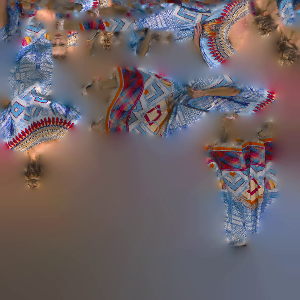

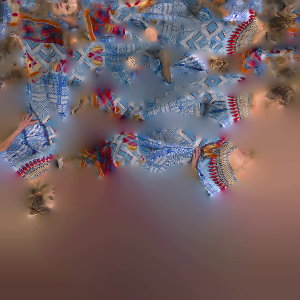

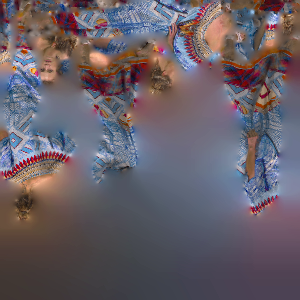

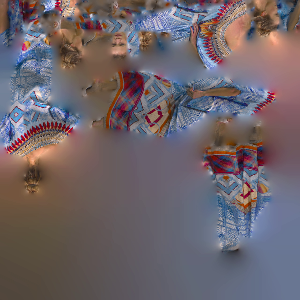

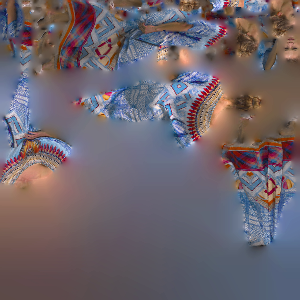

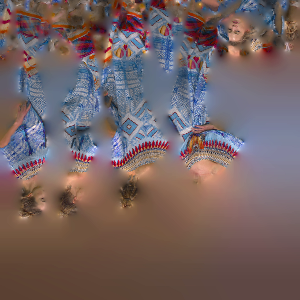

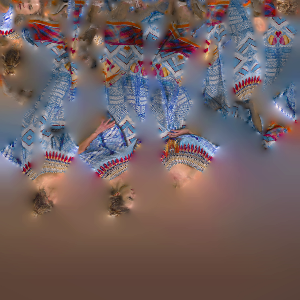

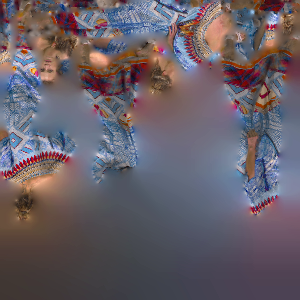

In [ ]:
#샘플 일부를 확인
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))
        

In [ ]:
data_set=os.path.join(base_dir,"image")
test_path=os.path.join(data_set,"test")
test_img_paths=sorted(
    [
     os.path.join(test_path,fname)
     for fname in os.listdir(test_path)
     if fname.endswith(".png")
    ]
)
# image 폴더아래 test 폴더를 생성하여 64개중  2개의 이미지를 test 폴더에 넣었음 image 10,11 번파일

In [ ]:
#이미지 자르기 및 크기 조정
# 먼저 이미지를 RGB 색상 공간에서 YUV 색상 공간으로 변환합니다 .

#입력 데이터 (저해상도 이미지)의 경우 이미지를 자르고 y채널 (휘도)을 검색 한 다음 area방법으로 크기를 조정합니다 
#( BICUBICPIL을 사용 하는 경우 사용). 인간은 휘도 변화에 더 민감하기 때문에 YUV 색 공간의 휘도 채널 만 고려합니다.

#대상 데이터 (고해상도 이미지)의 경우 이미지를 자르고 y채널을 검색



def process_input(input,input_size,upscale_factor):
    input=tf.image.rgb_to_yuv(input)
    
     
    last_dimensional_axis=len(input.shape)-1
    
    
    a,b,c=tf.split(input,3,axis=last_dimensional_axis)
    
    return tf.image.resize(a,[input_size,input_size],method='area')

def process_target(input):
    input=tf.image.rgb_to_yuv(input)
    last_dimensional_axis=len(input.shape)-1
    a,b,c=tf.split(input,3,axis=last_dimensional_axis)
    return a

train_ds=train_ds.map(
    lambda x:(process_input(x,input_size,upscale_factor),process_target(x))
)
train_ds=train_ds.prefetch(buffer_size=32)
valid_ds=valid_ds.map(
    lambda x: (process_input(x,input_size,upscale_factor),process_target(x))

)
valid_ds=valid_ds.prefetch(buffer_size=32)



1
2
3
1
2
3


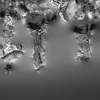

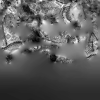

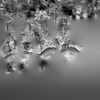

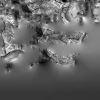

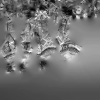

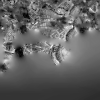

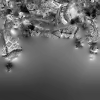

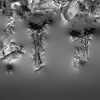

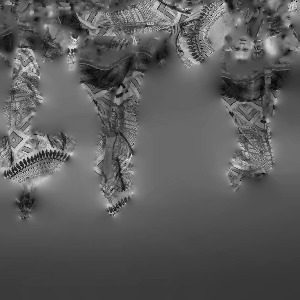

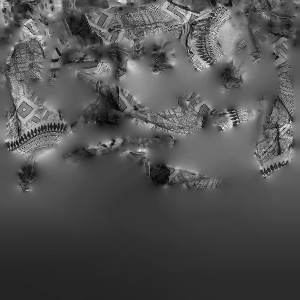

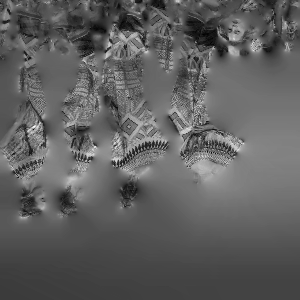

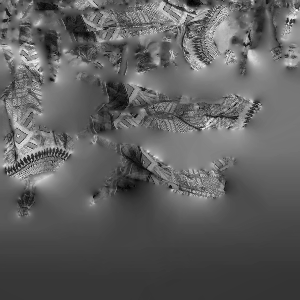

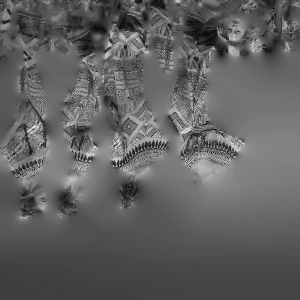

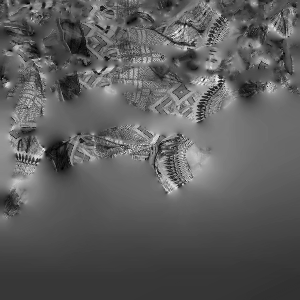

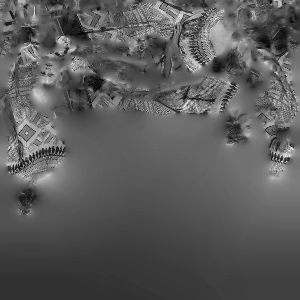

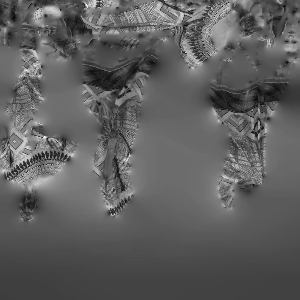

In [ ]:
# sample 일부를 확인
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

In [ ]:
# model 구축 
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(128, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL
# plot_results 저장 이미지를 플롯합니다.
# get_lowres_image 이미지를 저해상도 버전으로 변환합니다.
# upscale_image저해상도 이미지를 모델에 의해 재구성 된 고해상도 버전으로 전환합니다. 
# 이 함수에서는 yYUV 색상 공간 의 채널을 모델에 대한 입력으로 사용한 다음 출력을 다른 채널과 결합하여 RGB 이미지를 얻습니다.



def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [ ]:
# 훈련 모니터링을위한 콜백 정의
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))


In [ ]:
#정의 ModelCheckpoint및 EarlyStopping콜백
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf.nn.depth_to_space_1 (TFOp (None, None, None, 1)     0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
_______________________________________________________

Epoch 1/100
7/7 - 10s - loss: 0.0813 - val_loss: 2.1379e-04
Mean PSNR for epoch: 36.70


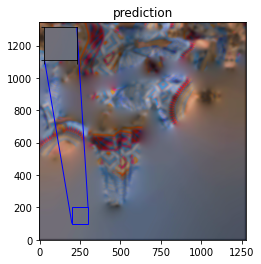

Epoch 2/100
7/7 - 10s - loss: 0.0292 - val_loss: 6.6524e-04
Mean PSNR for epoch: 31.77
Epoch 3/100
7/7 - 10s - loss: 0.0098 - val_loss: 0.0013
Mean PSNR for epoch: 28.93
Epoch 4/100
7/7 - 10s - loss: 0.0073 - val_loss: 0.0030
Mean PSNR for epoch: 25.17
Epoch 5/100
7/7 - 10s - loss: 0.0053 - val_loss: 0.0046
Mean PSNR for epoch: 23.35
Epoch 6/100
7/7 - 10s - loss: 0.0047 - val_loss: 0.0037
Mean PSNR for epoch: 24.33
Epoch 7/100
7/7 - 10s - loss: 0.0041 - val_loss: 0.0029
Mean PSNR for epoch: 25.37
Epoch 8/100
7/7 - 10s - loss: 0.0038 - val_loss: 0.0024
Mean PSNR for epoch: 26.18
Epoch 9/100
7/7 - 10s - loss: 0.0035 - val_loss: 0.0021
Mean PSNR for epoch: 26.69
Epoch 10/100
7/7 - 10s - loss: 0.0032 - val_loss: 0.0019
Mean PSNR for epoch: 27.13
Epoch 11/100
7/7 - 10s - loss: 0.0031 - val_loss: 0.0017
Mean PSNR for epoch: 27.66
Epoch 12/100
7/7 - 10s - loss: 0.0028 - val_loss: 0.0017
Mean PSNR for epoch: 27.73
Epoch 13/100
7/7 - 10s - loss: 0.0027 - val_loss: 0.0017
Mean PSNR for epoch: 27

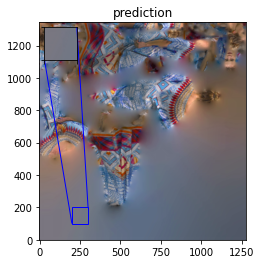

Epoch 22/100
7/7 - 10s - loss: 0.0020 - val_loss: 0.0013
Mean PSNR for epoch: 28.75
Epoch 23/100
7/7 - 10s - loss: 0.0019 - val_loss: 0.0012
Mean PSNR for epoch: 29.19
Epoch 24/100
7/7 - 10s - loss: 0.0019 - val_loss: 0.0012
Mean PSNR for epoch: 29.37
Epoch 25/100
7/7 - 10s - loss: 0.0019 - val_loss: 0.0011
Mean PSNR for epoch: 29.57
Epoch 26/100
7/7 - 10s - loss: 0.0019 - val_loss: 0.0010
Mean PSNR for epoch: 29.83
Epoch 27/100
7/7 - 10s - loss: 0.0018 - val_loss: 9.6421e-04
Mean PSNR for epoch: 30.16
Epoch 28/100
7/7 - 10s - loss: 0.0018 - val_loss: 9.1414e-04
Mean PSNR for epoch: 30.39
Epoch 29/100
7/7 - 10s - loss: 0.0018 - val_loss: 8.5820e-04
Mean PSNR for epoch: 30.66
Epoch 30/100
7/7 - 10s - loss: 0.0018 - val_loss: 8.0431e-04
Mean PSNR for epoch: 30.95
Epoch 31/100
7/7 - 10s - loss: 0.0018 - val_loss: 7.7822e-04
Mean PSNR for epoch: 31.09
Epoch 32/100
7/7 - 10s - loss: 0.0018 - val_loss: 7.1622e-04
Mean PSNR for epoch: 31.45
Epoch 33/100
7/7 - 10s - loss: 0.0018 - val_loss: 7.

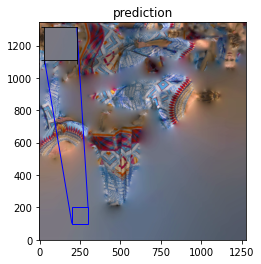

Epoch 42/100
7/7 - 10s - loss: 0.0018 - val_loss: 6.8351e-04
Mean PSNR for epoch: 31.65
Epoch 43/100
7/7 - 10s - loss: 0.0018 - val_loss: 6.2649e-04
Mean PSNR for epoch: 32.03
Epoch 44/100
7/7 - 10s - loss: 0.0017 - val_loss: 6.1258e-04
Mean PSNR for epoch: 32.12
Epoch 45/100
7/7 - 10s - loss: 0.0017 - val_loss: 6.0904e-04
Mean PSNR for epoch: 32.15
Epoch 46/100
7/7 - 10s - loss: 0.0017 - val_loss: 5.6172e-04
Mean PSNR for epoch: 32.50
Epoch 47/100
7/7 - 10s - loss: 0.0017 - val_loss: 5.5319e-04
Mean PSNR for epoch: 32.57
Epoch 48/100
7/7 - 10s - loss: 0.0017 - val_loss: 5.5853e-04
Mean PSNR for epoch: 32.53
Epoch 49/100
7/7 - 10s - loss: 0.0017 - val_loss: 5.1779e-04
Mean PSNR for epoch: 32.86
Epoch 50/100
7/7 - 10s - loss: 0.0017 - val_loss: 4.8092e-04
Mean PSNR for epoch: 33.18
Epoch 51/100
7/7 - 10s - loss: 0.0017 - val_loss: 4.2918e-04
Mean PSNR for epoch: 33.68
Epoch 52/100
7/7 - 10s - loss: 0.0017 - val_loss: 3.8660e-04
Mean PSNR for epoch: 34.12
Epoch 53/100
7/7 - 10s - loss: 0

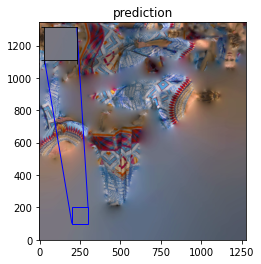

Epoch 62/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.5732e-04
Mean PSNR for epoch: 35.90
Epoch 63/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.5174e-04
Mean PSNR for epoch: 35.99
Epoch 64/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.5630e-04
Mean PSNR for epoch: 35.91
Epoch 65/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.5273e-04
Mean PSNR for epoch: 35.97
Epoch 66/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.9238e-04
Mean PSNR for epoch: 35.34
Epoch 67/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.7554e-04
Mean PSNR for epoch: 35.60
Epoch 68/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.6466e-04
Mean PSNR for epoch: 35.77
Epoch 69/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.6255e-04
Mean PSNR for epoch: 35.81
Epoch 70/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.7079e-04
Mean PSNR for epoch: 35.67
Epoch 71/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.6546e-04
Mean PSNR for epoch: 35.76
Epoch 72/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.5682e-04
Mean PSNR for epoch: 35.90
Epoch 73/100
7/7 - 10s - loss: 0

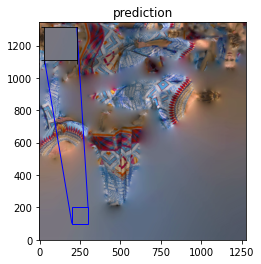

Epoch 82/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.6405e-04
Mean PSNR for epoch: 35.78
Epoch 83/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.5787e-04
Mean PSNR for epoch: 35.89
Epoch 84/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.4337e-04
Mean PSNR for epoch: 36.14
Epoch 85/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.4937e-04
Mean PSNR for epoch: 36.03
Epoch 86/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.4408e-04
Mean PSNR for epoch: 36.12
Epoch 87/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.4489e-04
Mean PSNR for epoch: 36.11
Epoch 88/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.6291e-04
Mean PSNR for epoch: 35.81
Epoch 89/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.4574e-04
Mean PSNR for epoch: 36.10
Epoch 90/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.4835e-04
Mean PSNR for epoch: 36.04
Epoch 91/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.5585e-04
Mean PSNR for epoch: 35.93
Epoch 92/100
7/7 - 10s - loss: 0.0017 - val_loss: 2.4504e-04
Mean PSNR for epoch: 36.11
Epoch 93/100
7/7 - 10s - loss: 0

In [ ]:
# 모델 training 
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)


model.load_weights(checkpoint_filepath)

PSNR of low resolution image and high resolution image is 32.6534
PSNR of predict and high resolution is 32.2697


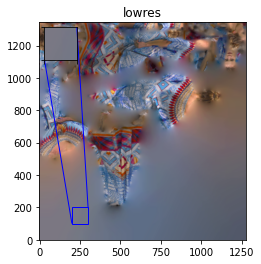

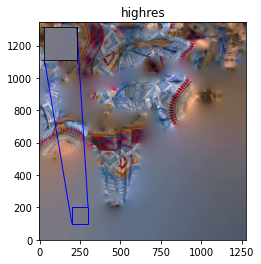

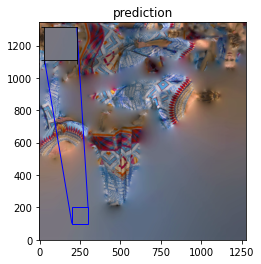

PSNR of low resolution image and high resolution image is 32.5219
PSNR of predict and high resolution is 32.1658


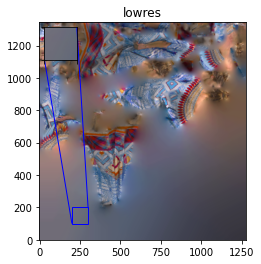

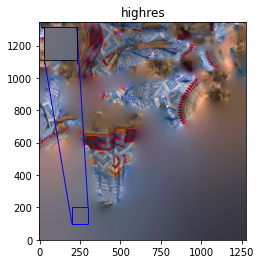

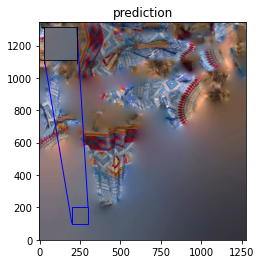

Avg. PSNR of lowres images is 6.5175
Avg. PSNR of reconstructions is 6.4436


In [ ]:
# 모델 예측 실행 및 결과 플로팅
# 몇 가지 이미지의 재구성 된 버전을 계산하고 결과를 저장
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))